In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import joblib

In [2]:
cancer = pd.read_csv('dataR2.csv')
print(cancer.shape)
cancer.head(2)

(116, 10)


,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1


In [3]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
print_unique(cancer)

Age 
 [24 25 28 29 32 34 35 36 38 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 57 58 59 60 61 62 64 65 66 67 68 69 71 72 73 74 75 76 77 78 81 82 83
 85 86 89] 

BMI 
 [18.37       18.67       19.13265306 19.56       20.26       20.69049454
 20.76       20.82999519 20.83       20.9566075  21.08281329 21.11111111
 21.30394858 21.35991456 21.36752137 21.47       21.51385851 22.
 22.03       22.21       22.22222222 22.4996371  22.65625    22.7
 22.83287935 22.85445769 22.86       22.89281998 23.         23.01
 23.12467037 23.14049587 23.34       23.5        23.62       23.8
 24.21875    24.24242424 24.74       25.3        25.51020408 25.59
 25.7        25.9        26.34929208 26.5625     26.6        26.66666667
 26.6727633  26.84       26.85       27.1        27.18       27.2
 27.3        27.63605442 27.68877813 27.7        27.88761707 27.91551882
 28.125      28.44444444 28.57667585 28.65013774 28.67262608 29.13631634
 29.15451895 29.2184076  29.296875   29.38475666 29.4        29.606

In [4]:
def snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

snapshot = snapshot(cancer)
snapshot

,n_unique,dtype,n_missing,pct_missing
Age,51,int64,0,0.0
BMI,110,float64,0,0.0
Glucose,50,int64,0,0.0
Insulin,113,float64,0,0.0
HOMA,116,float64,0,0.0
Leptin,116,float64,0,0.0
Adiponectin,115,float64,0,0.0
Resistin,116,float64,0,0.0
MCP.1,113,float64,0,0.0
Classification,2,int64,0,0.0


In [5]:
np.sort(snapshot['n_unique'].unique())

array([  2,  50,  51, 110, 113, 115, 116], dtype=int64)

In [6]:
features = cancer.columns.drop('Classification')

In [7]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    df[col].value_counts().plot.bar(color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()

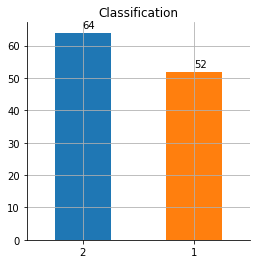

In [8]:
plot_single_categorical(cancer, 'Classification')

In [9]:
def feat_significance(X, y, n_feat_data_type, features):
    mi_df = pd.DataFrame(mutual_info_classif(X, y, random_state = 42), index = X.columns, columns = ['score'])
    mi_df = mi_df.sort_values(by = 'score', ascending = False)
    
    def color_cell(s):    
        background = []
        for i in range(len(s.index)):
            if s.index[i] in features:
                background.append('background-color: yellow')
            else:
                background.append('')
        return background
    
    if n_feat_data_type == 1:
        return mi_df
    else:
        return mi_df.style.apply(color_cell, axis = 0)

In [11]:
feat_score = feat_significance(cancer[features], cancer['Classification'], 1, '')
feat_score

,score
Age,0.134886
Glucose,0.069120
Resistin,0.057669
HOMA,0.016421
BMI,0.000000
Insulin,0.000000
Leptin,0.000000
Adiponectin,0.000000
MCP.1,0.000000


In [14]:
X_scaled = pd.DataFrame(scale(cancer[features]), columns = features)
y = cancer['Classification']

In [16]:
lr = LogisticRegression(random_state = 42)
knn = KNeighborsClassifier()
svc = SVC(random_state = 42)
tree = DecisionTreeClassifier(max_features = 'auto', random_state = 42)
alg_dict = {lr: 'lr', svc: 'svc', knn: 'knn', tree: 'tree'}

In [17]:
def num_feat_perform(algorithm, feat_ordered, X_ordered, y, metric):
    scores = []
    for i in range(1, len(feat_ordered)+1):
        pred_data = X_ordered.iloc[:, 0:i]
        score = mean(cross_val_score(algorithm, pred_data, y, scoring = metric, cv = 5))
        scores.append(score)

    n_features = len(feat_ordered)
    plt.plot(np.arange(n_features), scores, marker = 'x')
    plt.xticks(np.arange(n_features), np.arange(1, n_features + 1))
    for i in range(n_features):
        plt.text(i, scores[i], s = round(scores[i], 2))
    plt.grid()
    plt.xlabel('no. of features')
    plt.ylabel('score')
    
def num_feat_multi_alg(alg_dict, feat_ordered, X_ordered, y, metric):
    n_algorithm = len(alg_dict)
    algorithms = list(alg_dict.keys())
    alg_names = list(alg_dict.values())
    if n_algorithm <= 2:
        nrows = 1
        ncols = n_algorithm
        fig = plt.figure(figsize = (ncols * 6, 4))
    else:
        nrows = math.ceil(n_algorithm / 2)
        ncols = 2
        fig = plt.figure(figsize = (12, nrows * 4))

    for n in range(n_algorithm):
        ax = fig.add_subplot(nrows, ncols, n + 1)
        ax = num_feat_perform(algorithms[n], feat_ordered, X_ordered, y, metric)
        plt.title(f"'{alg_names[n]}' performance by '{metric}'")
        
    plt.tight_layout()
    plt.show()

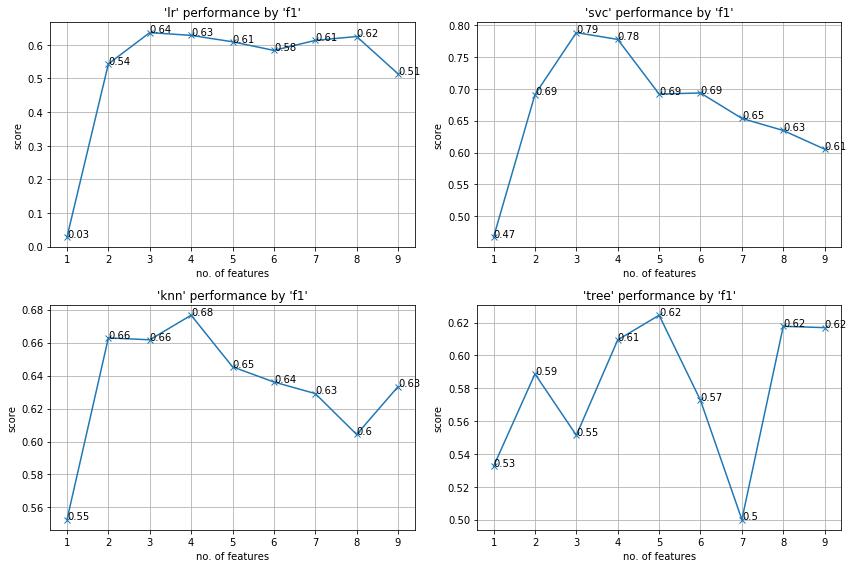

In [18]:
num_feat_multi_alg(alg_dict, feat_score.index, X_scaled[feat_score.index], y, 'f1')

In [19]:
def plot_learning_curve(train_scores, test_scores, train_sizes):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
def two_metric_graph(algorithm, X, y):
    train_sizes = np.linspace(start = 20, stop = X.shape[0] * 0.8, num = 6, dtype = int)
    fig = plt.figure(figsize = (10, 4))

    for i, metric in enumerate(['f1', 'balanced_accuracy']):
        train_sizes_abs, train_scores, test_scores = learning_curve(algorithm, X, y, train_sizes = train_sizes, 
                                                                    scoring = metric, cv = 5, shuffle = True, 
                                                                    random_state = 42)
        ax = fig.add_subplot(1, 2, i + 1)
        ax = plot_learning_curve(train_scores, test_scores, train_sizes)
        plt.title(f"'performance by '{metric}'")

    plt.tight_layout()
    plt.show()

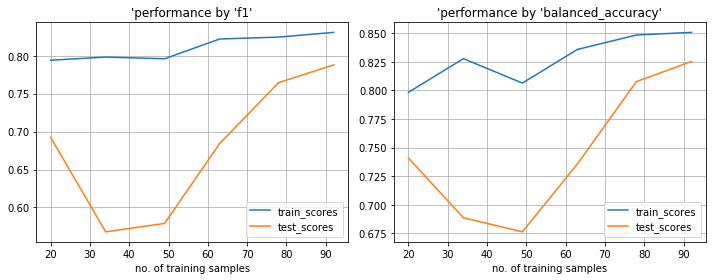

In [21]:
two_metric_graph(svc, X_scaled[feat_score.index[0:3]], y)

In [23]:
svc.fit(X_scaled[feat_score.index[0:3]], y)
joblib.dump(svc, 'svc.joblib')

['svc.joblib']